<a href="https://colab.research.google.com/github/bonareri/Machine-Learning/blob/main/spotify_reviews_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of App Reviews

**Introduction**

- **Objective:** The goal of this project is to analyze app reviews and classify their sentiment as positive, neutral, or negative. This helps businesses understand user feedback and improve their products.
- **Dataset:** The dataset contains app reviews labeled with their corresponding sentiment. For this project, we used a sample of 500 reviews from a larger dataset.

## Import necessary libraries

In [94]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

In [95]:
#loading data
df = pd.read_csv('/content/reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [96]:
# dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


## 1. Preprocessing the Data:

### 1.1 Drop unnecessary columns and handle missing values

In [97]:
# Drop 'Time_submitted' and 'Reply' columns
df = df.drop(columns=['Time_submitted', 'Reply'])

# Check for any missing values
df.isnull().sum()

,0
Review,0
Rating,0
Total_thumbsup,0


### 1.2 Create a target column (Sentiment) based on the Rating column

- Positive sentiment can be assigned for ratings 4 and 5.
- Negative sentiment for ratings 1 and 2.
- Neutral sentiment for ratings 3.

In [98]:
# Create a new 'Sentiment' column based on 'Rating'
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment'] = df['Rating'].apply(map_sentiment)

In [99]:
df_500 = df.head(10000)
df_500.head()

,Review,Rating,Total_thumbsup,Sentiment
0,"Great music service, the audio is high quality...",5,2,positive
1,Please ignore previous negative rating. This a...,5,1,positive
2,"This pop-up ""Get the best Spotify experience o...",4,0,positive
3,Really buggy and terrible to use as of recently,1,1,negative
4,Dear Spotify why do I get songs that I didn't ...,1,1,negative


### 1.3 Text Preprocessing using spaCy

In [100]:
# Load the Spacy model
nlp = spacy.load('en_core_web_sm')

In [101]:
def clean_text_spacy(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Lemmatize and remove stopwords and punctuation
    cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

    return cleaned_text

In [102]:
# Apply the clean_text_spacy function to the review column
df_500['Cleaned_Review'] = df_500['Review'].apply(clean_text_spacy)

# Check the cleaned reviews
df_500[['Review', 'Cleaned_Review']].head()

<ipython-input-102-7661399246f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Cleaned_Review'] = df_500['Review'].apply(clean_text_spacy)


,Review,Cleaned_Review
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...
1,Please ignore previous negative rating. This a...,ignore previous negative rating app super grea...
2,"This pop-up ""Get the best Spotify experience o...",pop good spotify experience Android 12 annoyin...
3,Really buggy and terrible to use as of recently,buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,Dear Spotify song playlist shuffle play


## 3. Feature Extraction

N-grams (Unigrams + Bigrams): You've already included bigrams, which can help capture more complex patterns in the text. You might consider using higher-order n-grams (e.g., trigrams) if you feel the model isn't capturing enough context.

In [103]:
# Convert text data to numerical features using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = vectorizer.fit_transform(df_500['Cleaned_Review'])  # Transform the cleaned reviews

Sentiment Lexicons: Using a sentiment lexicon (e.g., VADER or SentiWordNet) can help capture sentiment scores for words and phrases in the reviews. Neutral sentiment is often more context-sensitive, so having sentiment scores as features can help.

In [104]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [105]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to get the sentiment score
def get_sentiment_score(review):
    return sia.polarity_scores(review)['compound']

# Apply sentiment score extraction
df_500['Sentiment_Score'] = df_500['Review'].apply(get_sentiment_score)

# Include sentiment score as a feature in the model
X = vectorizer.fit_transform(df_500['Cleaned_Review']).toarray()
X_with_sentiment = np.column_stack((X, df_500['Sentiment_Score']))

<ipython-input-105-ce0e070f75aa>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Sentiment_Score'] = df_500['Review'].apply(get_sentiment_score)


### Visualize the Sentiment Analysis ResultsVisualize the Sentiment Analysis Results

### Sentiment Distribution

<ipython-input-106-8de15c80d8c4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


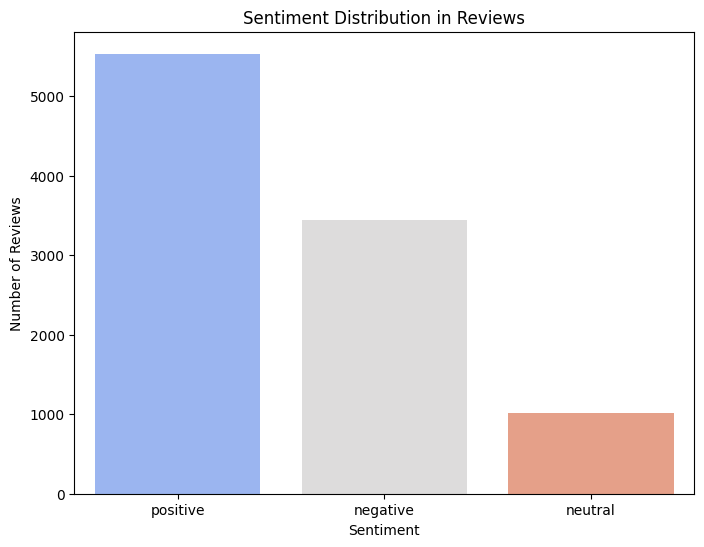

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each sentiment
sentiment_counts = df_500['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Distribution in Reviews')
plt.show()

### Rating Distribution

<ipython-input-30-984f64eb1af5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_500, x='Rating', palette='coolwarm')


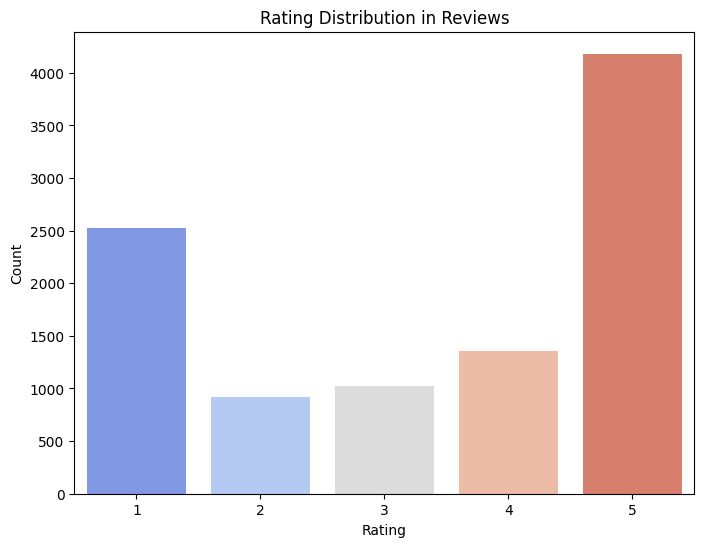

In [30]:
# Plot the rating distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df_500, x='Rating', palette='coolwarm')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution in Reviews')
plt.show()

### Visualizing Sentiment vs Rating

To get a better understanding of how the sentiments correlate with ratings, we can visualize sentiment in relation to the rating.

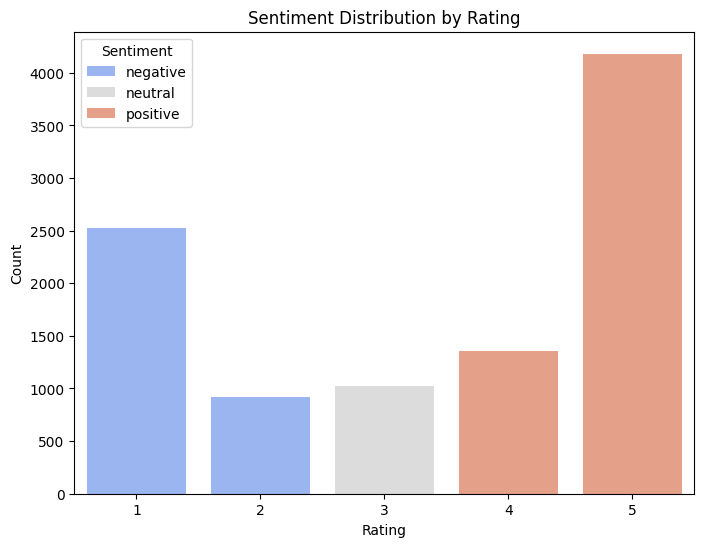

In [31]:
# Plot sentiment vs rating
plt.figure(figsize=(8, 6))
sns.countplot(data=df_500, x='Rating', hue='Sentiment', palette='coolwarm')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Rating')
plt.show()

### Wordcloud for Sentiment Analysis

In [32]:
from wordcloud import WordCloud

In [33]:
# Create a word cloud for each sentiment
positive_reviews = " ".join(df_500[df_500['Sentiment'] == 'positive']['Cleaned_Review'])
neutral_reviews = " ".join(df_500[df_500['Sentiment'] == 'neutral']['Cleaned_Review'])
negative_reviews = " ".join(df_500[df_500['Sentiment'] == 'negative']['Cleaned_Review'])

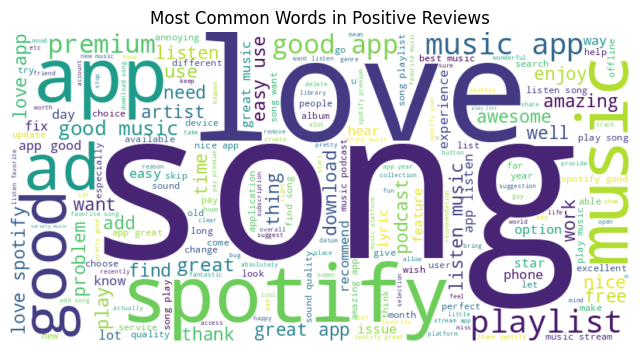

In [34]:
# Plot wordcloud for positive sentiment
plt.figure(figsize=(8, 6))
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews')
plt.axis('off')
plt.show()

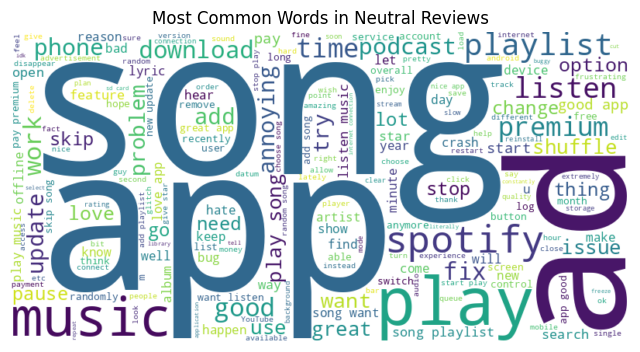

In [35]:
# Plot wordcloud for neutral sentiment
plt.figure(figsize=(8, 6))
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Neutral Reviews')
plt.axis('off')
plt.show()

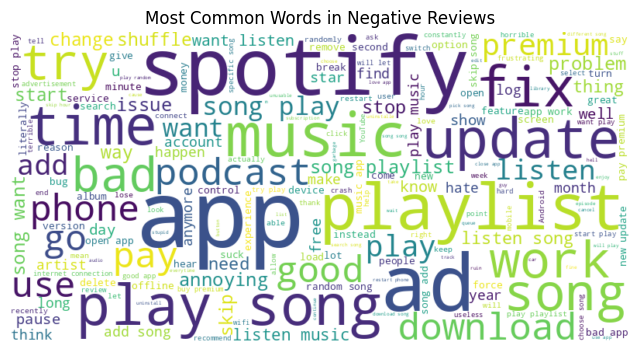

In [36]:
# Plot wordcloud for negative sentiment
plt.figure(figsize=(8, 6))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews')
plt.axis('off')
plt.show()

## Handling class imbalance




In [108]:
# Encode the target sentiment labels
label_encoder = LabelEncoder()
df_500['Sentiment_Encoded'] = label_encoder.fit_transform(df_500['Sentiment'])
y = df_500['Sentiment_Encoded']

<ipython-input-108-1920a42cf9b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Sentiment_Encoded'] = label_encoder.fit_transform(df_500['Sentiment'])


### Train-Test Split

In [109]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Handle class imbalance using SMOTE (oversampling)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Modelling

### Logistic Regression

In [72]:
# Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_smote, y_train_smote)
log_reg_pred = log_reg_model.predict(X_test)

In [73]:
print("Logistic Regression Model Evaluation:")
print(classification_report(y_test, log_reg_pred, target_names=label_encoder.classes_))

Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

    negative       0.71      0.75      0.73       669
     neutral       0.21      0.33      0.26       192
    positive       0.91      0.79      0.84      1139

    accuracy                           0.73      2000
   macro avg       0.61      0.62      0.61      2000
weighted avg       0.77      0.73      0.75      2000



### Support Vector Machine Model

In [92]:
# Support Vector Machine Model
svm_model = SVC()
svm_model.fit(X_train_smote, y_train_smote)
svm_pred = svm_model.predict(X_test)

In [93]:
print("Support Vector Machine (SVM) Model Evaluation:")
print(classification_report(y_test, svm_pred, target_names=label_encoder.classes_))

Support Vector Machine (SVM) Model Evaluation:
              precision    recall  f1-score   support

    negative       0.67      0.77      0.72       669
     neutral       0.13      0.04      0.06       192
    positive       0.81      0.85      0.83      1139

    accuracy                           0.74      2000
   macro avg       0.54      0.55      0.54      2000
weighted avg       0.70      0.74      0.72      2000



### Random Forest Model

In [76]:
# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_smote, y_train_smote)
rf_pred = rf_model.predict(X_test)

In [77]:
print("Random Forest Model Evaluation:")
print(classification_report(y_test, rf_pred, target_names=label_encoder.classes_))

Random Forest Model Evaluation:
              precision    recall  f1-score   support

    negative       0.65      0.86      0.74       669
     neutral       0.21      0.04      0.06       192
    positive       0.87      0.83      0.85      1139

    accuracy                           0.76      2000
   macro avg       0.58      0.58      0.55      2000
weighted avg       0.73      0.76      0.74      2000



### XGBoost Model

In [78]:
# XGBoost Model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_smote, y_train_smote)
xgb_pred = xgb_model.predict(X_test)

In [79]:
print("XGBoost Model Evaluation:")
print(classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))

XGBoost Model Evaluation:
              precision    recall  f1-score   support

    negative       0.68      0.83      0.75       669
     neutral       0.23      0.15      0.18       192
    positive       0.88      0.82      0.85      1139

    accuracy                           0.76      2000
   macro avg       0.60      0.60      0.59      2000
weighted avg       0.75      0.76      0.75      2000



## Evaluation Metrics

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame for actual vs predicted labels
df_errors = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Filter the rows where prediction is incorrect
misclassified = df_errors[df_errors['Actual'] != df_errors['Predicted']]

# Plot the count of misclassifications by class
misclassified_counts = misclassified['Actual'].value_counts()
misclassified_counts.plot(kind='bar', color='salmon')
plt.title('Misclassifications by Class')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


In [ ]:
correct = df_errors[df_errors['Actual'] == df_errors['Predicted']]
correct_counts = correct['Actual'].value_counts()

# Plot for correct and incorrect classifications
plt.figure(figsize=(10, 6))
plt.bar(correct_counts.index, correct_counts.values, label="Correct", alpha=0.7)
plt.bar(misclassified_counts.index, misclassified_counts.values, label="Incorrect", alpha=0.7)
plt.title('Actual vs Predicted Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
# Extract the rows where predictions were incorrect
misclassified_instances = df_errors[df_errors['Actual'] != df_errors['Predicted']]

# Display the actual and predicted values for a few errors
print(misclassified_instances.head())

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=df_500.Sentiment.unique(), output_dict=True)


# Convert report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='Blues', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

## Predictions

In [ ]:
# Example prediction on Spotify reviews
new_review = ["The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue."]

# Clean the review using the same cleaning function
new_review_cleaned = [clean_text(review) for review in new_review]

# Tokenize the cleaned review and generate embeddings using Word2Vec
new_review_embedded = [embed_review(review, word2vec_model) for review in new_review_cleaned]

# Convert the embeddings into a numpy array (same as for the training data)
new_review_embedded = np.array(new_review_embedded)

# Ensure the feature matrix is in the same shape as the training data
new_review_embedded = np.vstack(new_review_embedded)

# Make a prediction using the trained model
prediction = model.predict(new_review_embedded)

# Define the label mapping (if needed)
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Output the prediction with a label
print(f"Predicted sentiment: {label_mapping[prediction[0]]}")  # This will print the predicted sentiment (positive, negative, neutral)

In [ ]:
# Example prediction on a new Spotify review
new_review = ["The app keeps crashing and the playlist recommendations are awful."]

# Clean the review using the same cleaning function
new_review_cleaned = [clean_text(review) for review in new_review]

# Tokenize the cleaned review and generate embeddings using Word2Vec
new_review_embedded = [embed_review(review, word2vec_model) for review in new_review_cleaned]

# Convert the embeddings into a numpy array (same as for the training data)
new_review_embedded = np.array(new_review_embedded)

# Ensure the feature matrix is in the same shape as the training data
new_review_embedded = np.vstack(new_review_embedded)

# Make a prediction using the trained model
prediction = model.predict(new_review_embedded)

# Define the label mapping (if needed)
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Get the predicted sentiment label
predicted_sentiment = label_mapping[prediction[0]]

# Output the prediction with enhanced context
print(f"Review: {new_review[0]}")
print(f"Predicted sentiment: {predicted_sentiment} ({prediction[0]})")